# Federated Machine Learning in PyTorch

This notebook is a demonstration of _federated learning_, an approach to training a machine learning model by combining the results of training local models on multiple devices.

This notebook is part of a series intended to start from the basics to demonstrate federated learning in `pytorch`, then move on to test some of the bounds of what federated learning can (and can't) do.

## The Task: Digit Recognition

For this demonstration, our task is a classic one: the MNIST digit recognition task. Specifically, we need to determine which number is written in an image of a handwritten digit like this one: 

![Handwritten digit "6"](images/example-6.png)

To carry out this task we need a machine learning model to "look" at an image and classify it into a number. We also need and image data to train the model. We're going to use a simple convolutional neural network model. For the training images, we're using the well-known MNIST digits dataset.

## The Approach: Federation

The federated approach uses several _worker_ devices to train their own local models with independent data. That is, the workers each train their own local model with a subset of the full dataset.

Each worker trains its local model for a bit, then sends its incrementally trained local model back to a _manager_. The manager combines the local models from all of the workers into a master model, then sends the master model back to the workers. This process is called a _round_. 

Then another round begins: the workers each train their local copy of the master model (creating another set of individualized local models), send those local models back to the manager. Once again the manager combines these individualized local models into a new master model, and pushes the new master model down to the workers. This cycle of rounds repeats as long as is necessary and useful.

## Our Federation Library

The `federated` library we're using here is a *simulation* of a federated network. It's not *true* federated learning because it uses one machine to simulate several indepedent machines. This means it does not have to deal with network communication or the timing problems inherent to parallelism. But the "local" models are independent and that is sufficient to demonstrate the principles underlying federated learning.

Our library includes a `FederatedManager` class and a `FederatedWorker` class. A `FederatedManager` contains a master prediction model and creates several independent `FederatedWorker` instances. Each `FederatedWorker` has its own local model and a distinct subset of the MNIST data.

In each `round` of federated learning, each `FederatedWorker` trains its local model using only the data that that worker recieves, and then sends its trained local model to the `FederatedManager`. The `FederatedManager` combines the models into an updated master model and pushes that new master model down to each `FederatedWorker`. There are a number of algorithms available for combining local models. Our library uses [federated averaging](https://arxiv.org/abs/1602.05629), a very simple element-by-element average of the model's weights.

We're going to see how federation works and test out some corner cases here. Let's get started with the code.

## The Model

Now we define the model. We're using the [sample model from the `pytorch` package](https://github.com/pytorch/examples/blob/master/mnist/main.py).

In [1]:
# Define the model

import torch.nn as nn
import torch.nn.functional as F

'''   

# THIS IS THE OFFICIAL PYTORCH EXAMPLE, BUT IT'S SLOWER THAN THE OTHER MODEL, SO FOR NOW, IT'S FAST BEFORE TIDY

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output
'''

# Quick and gets the job done well enough for testing
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 500)
        self.fc2 = nn.Linear(500, 256)
        self.fc3 = nn.Linear(256, 10)
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x
#'''

## The Data - Standard MNIST Datasets
Here we get plain vanilla MNIST data, a training set and a test set, from the `pytorch` package, again using the same transforms as their example.

If you don't already have the MNIST data on your machine, the setting `download=True` in the call to `torchvision.datasets.MNIST()` will fetch it for you.

In [2]:
# acquire the data and create standard MNIST datasets

import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms

# create standard datasets using all of the MNIST data
data_path = './MNIST-data/raw'

trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

train_dset = dsets.MNIST(root=data_path, download=True, train=True, transform=trans)
test_dset = dsets.MNIST(root=data_path, download=True, train=False, transform=trans)

print("Train dataset size: ", len(train_dset))
print("Test dataset size : ", len(test_dset))

Train dataset size:  60000
Test dataset size :  10000


Now we have our standard MNIST datasets: `train_dset` contains 60,000 examples, and `test_dset` contains 10,000 samples.

In [3]:
# create dataloaders

from torch.utils.data import DataLoader

train_batch_size = 64
test_batch_size = 1000

# create standard dataloaders using all of the MNIST data
train_dloader = DataLoader(train_dset, batch_size=train_batch_size, shuffle=True)
test_dloader = DataLoader(test_dset, batch_size=test_batch_size, shuffle=True)

Let's check out the default data. The out-of-the-box MNIST dataset has roughly equal numbers of samples for each digit, i.e., about as many samples of `4`s as `6`s (though the set is a *little* heavy on `1`s and a *little* light on `5`s).

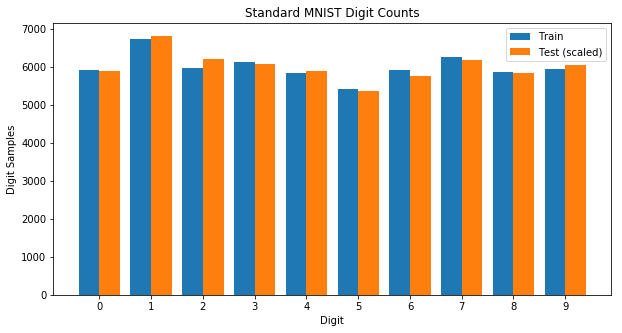

In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title('Standard MNIST Digit Counts')
ax.set_xlabel('Digit')
ax.set_ylabel('Digit Samples')
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.hist([train_dloader.dataset.targets.tolist(), test_dloader.dataset.targets.tolist()*6], 
        label=['Train', 'Test (scaled)'],
        bins=list(range(11)), 
        histtype='bar',
        align='left',
        rwidth=0.8,
       )
ax.legend();

The training data is reasonably well distributed, and the plots above confirm it. We scaled up the test set counts by a factor of six to make them comparable to the training set, which has exactly six times as many examples as the test set.

## Baseline: The Non-Federated Approach

To show a baseline of non-federated learning, we train a model using just one worker (we're technically using the federated library, but with one worker, it's equivalent to non-federated learning). This one worker will train on the full standard MNIST dataset of 60,000 examples.

TODO: AND THEN DO WE WANT TO SHOW A MODEL TRAINED ONLY ON ONE SKEWED DATASET?

TODO: Explain (and apologize?) the hack to measure the length of a dataset? Or find another way?

In [5]:
import federated as fed
import federated_mnist as fm
from tqdm.notebook import trange

num_rounds = 100

def make_manager(name,
                 train_dloaders, 
                 test_dset, 
                 model=Net, 
                 verbose=False,
                 lr=1e-2,
                 n_epochs=1,
                ):
    
    if not isinstance(train_dloaders, list):
        train_dloaders = [train_dloaders]
        
    return fed.FederatedManager(train_dloaders, model, test_dset, n_epochs=n_epochs, lr=lr, verbose=verbose, name=name)

def run_manager(mgr, num_rounds, target_acc=None):
    
    target_met = False;
    
    if (target_acc):
        print(mgr.name, 'manager training with', mgr.n_workers, 'worker(s) for up to', num_rounds, 'rounds or', target_acc, '% accuracy.')
    else:
        print(mgr.name, 'manager training with', mgr.n_workers, 'worker(s) for', num_rounds, 'rounds.')

    for i in trange(num_rounds, desc='Rounds'):
        if(mgr.verbose):
            print('Round', i)
        mgr.round()
        if(mgr.verbose):
            print(
                '\tcombined\tloss: {:.4f}\tacc: {:.2%}\n'.format(
                    mgr.history['test_loss'][-1],
                    mgr.history['test_acc'][-1] / 100,
                )
            )
            
        if(target_acc and (mgr.history['test_acc'][-1] >= target_acc)):
            target_met = True
            break;

    if(target_met):
        print(mgr.name, 'manager stopping: met accuracy target of', target_acc, '% after', len(mgr.history['test_acc']), 'rounds. (Accuracy', mgr.history['test_acc'][-1], '% and loss', mgr.history['test_loss'][-1]))
    else:
        print(mgr.name, 'manager trained', len(mgr.history['test_acc']), 'rounds. Final accuracy', mgr.history['test_acc'][-1], '% and loss', mgr.history['test_loss'][-1])

print("Dataset size: ", len(train_dloader.dataset))

Dataset size:  60000


In [6]:
default_manager = make_manager('Non-Federated', train_dloader, test_dset)
run_manager(default_manager, num_rounds, target_acc=95.0)

Non-Federated manager training with 1 worker(s) for up to 100 rounds or 95.0 % accuracy.


Stopping: met accuracy target of 95.0 % (reached 95.67 % accuracy after 3 rounds.)


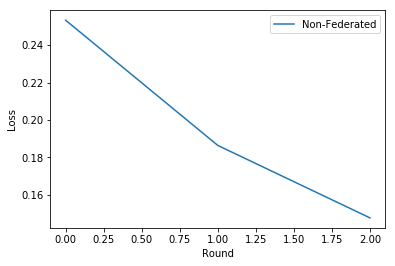

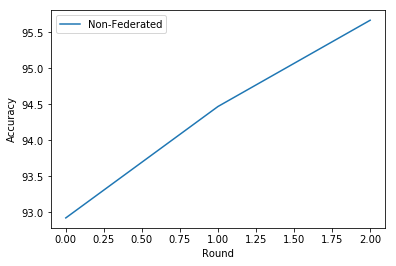

In [7]:
def plot_mgr(mgrs, plot_workers=False):
    
    if not isinstance(mgrs, list):
        mgrs = [mgrs]
    
    fig, ax = plt.subplots()
    for m in mgrs:
        ax.plot(m.history['test_loss'], label=m.name)
        if(plot_workers):
            for w in m.workers:
                ax.plot(w.history['test_loss'], label=(m.name, 'Worker ' + str(w.name)))
    ax.set_xlabel("Round")
    ax.set_ylabel("Loss")
    ax.legend();
    
    fig, ax = plt.subplots()
    for m in mgrs:
        ax.plot(m.history['test_acc'], label=m.name)
        if(plot_workers):
            for w in m.workers:
                ax.plot(w.history['test_acc'], label=(m.name, 'worker ' + str(w.name)))
    ax.set_xlabel("Round")
    ax.set_ylabel("Accuracy")
    ax.legend();
    
plot_mgr(default_manager)

# The Federated Approach

Now that we have a baseline using the traditional approach. we perform the same task using the federated learning approach.

## Splitting the Deck Into Piles

To illustrate federated learning we use several workers, each representing a device in the field. For now, we'll assume our workers are exposed to similar types and amounts of data, say, a thermostat reporting temperature and humidity every ten minutes. The analog here in MNIST is a subset of training examples for each worker. Here, we'll use ten workers. Our `pytorch` implementation will create a training `DataLoader` for each worker (and we we'll leave the test `DataLoader` as it is in the raw MNIST `Dataset`.

In [8]:
import federated_mnist as fm

from collections import Counter
import numpy as np
from tqdm.notebook import tqdm

fed_constant_n_dloaders = fm.make_stacked_dloaders(train_dset, p=0.0)

fm.check_dsets([dl.dataset for dl in fed_constant_n_dloaders])

Distributions
Counter({1: 694, 7: 620, 9: 603, 6: 598, 2: 598, 0: 596, 8: 582, 5: 579, 3: 569, 4: 528})
Counter({1: 678, 3: 648, 7: 641, 9: 595, 4: 589, 6: 588, 2: 576, 0: 566, 8: 565, 5: 523})
Counter({1: 650, 3: 628, 2: 625, 7: 618, 9: 615, 0: 612, 8: 608, 6: 599, 4: 568, 5: 525})
Counter({1: 657, 7: 650, 3: 611, 9: 606, 8: 599, 6: 591, 2: 577, 0: 577, 4: 555, 5: 536})
Counter({1: 698, 6: 642, 9: 621, 3: 617, 4: 605, 7: 600, 2: 600, 5: 564, 0: 559, 8: 558})
Counter({1: 660, 7: 621, 3: 620, 9: 601, 8: 588, 0: 586, 2: 584, 6: 578, 4: 564, 5: 512})
Counter({1: 688, 7: 614, 4: 613, 8: 605, 3: 587, 6: 581, 0: 580, 2: 564, 9: 546, 5: 542})
Counter({1: 657, 0: 631, 2: 613, 7: 611, 3: 594, 4: 583, 6: 574, 8: 572, 9: 568, 5: 568})
Counter({1: 679, 7: 647, 4: 634, 9: 624, 0: 618, 3: 603, 8: 595, 2: 586, 6: 565, 5: 551})
Counter({1: 681, 3: 654, 7: 643, 2: 635, 4: 603, 6: 602, 0: 598, 8: 579, 9: 570, 5: 521})


In [ ]:
fig, ax = plt.subplots()
ax.set_title('MNIST Subset Digit Counts')
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.set_ylabel('Digit Samples')
ax.set_xlabel('Digits Grouped by Worker')
H = ax.hist(hist_counts, bins=range(11), histtype='bar', align='left', rwidth=0.8)


##TODO CONFIRM WHAT IM SEEING HERE

So we can see that each of our ten workers has about the same number of each digit, i.e., the digit `5` is spread pretty evenly across the workers, and is probably lower in number for any given worker than the digit `1`, `1` being the most frequent digit in the MNIST set.

In [9]:
fed_constant_n_manager = make_manager('Federated Equal', fed_constant_n_dloaders, test_dset)

run_manager(fed_constant_n_manager, num_rounds, target_acc=95.0)

Federated Equal manager training with 10 worker(s) for up to 100 rounds or 95.0 % accuracy.


Stopping: met accuracy target of 95.0 % (reached 95.22 % accuracy after 24 rounds.)


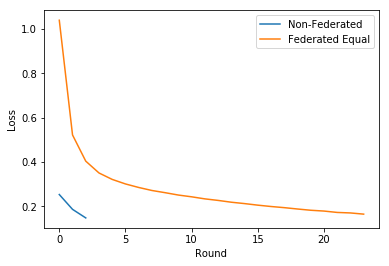

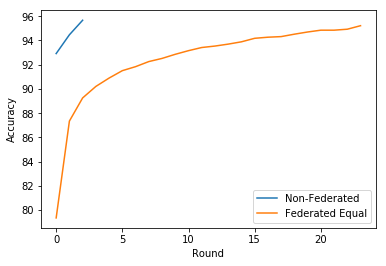

In [10]:
plot_mgr([default_manager, fed_constant_n_manager])

TODO: WHAT DID WE SEE??!?!?!!eleventy!

# Federation with Varying Example Counts

Now we've seen federation work with a dataset scattered across a number of workers. And we saw that its performance isn't substantially different from the non-federated approach, while decentralizing the work of training and limiting the amount of data transfered between the main manager and the workers.

But what if our workers don't have access to equal amounts of data? Let's explore that.

## Spliting the Deck into Uneven Piles

To test this, we need workers to have access to different numbers of training examples. So let's make a set of decks that gives each of our workers more or less training data than the others.

# EVERYTHING BELOW HERE IS SANDBOX

In [11]:
import federated_mnist as fm

def eval_mgr(name, train_dset, test_dset, p=0.0, num_rounds=50, target_acc=None):
    
    dls = fm.make_stacked_dloaders(train_dset, p=p)
    mgr = make_manager(name, dls, test_dset)
    run_manager(mgr, num_rounds, target_acc=target_acc)
    plot_mgr(mgr)
    return mgr

Fed Bias 0.60 manager training with 10 worker(s) for 3 rounds.


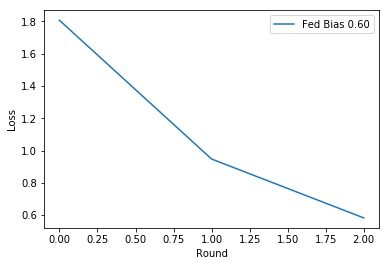

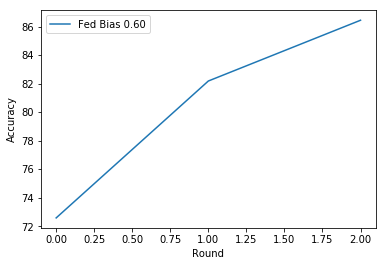

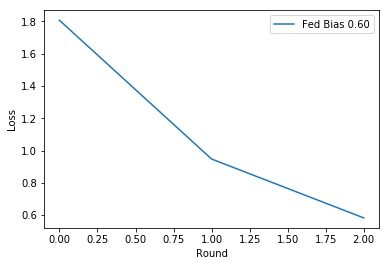

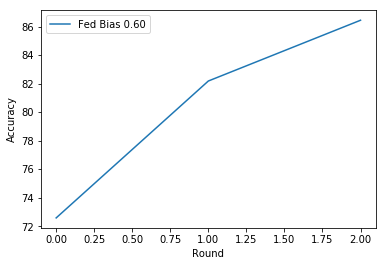

In [12]:
fed_060_mgr = eval_mgr('Fed Bias 0.60', train_dset, test_dset, p=0.60, num_rounds=3, target_acc=None)

plot_mgr(fed_060_mgr)

Fed Bias 0.0 manager training with 10 worker(s) for 100 rounds.



Fed Bias 0.1 manager training with 10 worker(s) for 100 rounds.



Fed Bias 0.6 manager training with 10 worker(s) for 100 rounds.



Fed Bias 0.9 manager training with 10 worker(s) for 100 rounds.



Fed Bias 0.95 manager training with 10 worker(s) for 100 rounds.



Fed Bias 0.98 manager training with 10 worker(s) for 100 rounds.



Fed Bias 0.999 manager training with 10 worker(s) for 100 rounds.


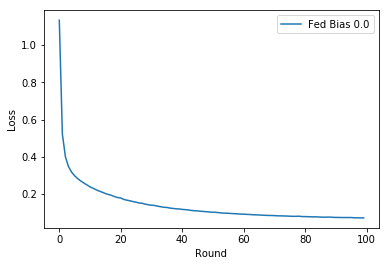

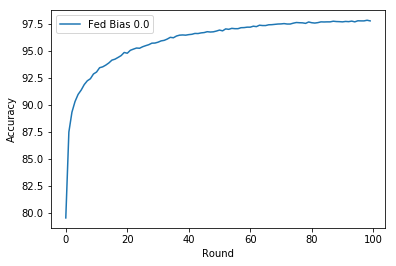

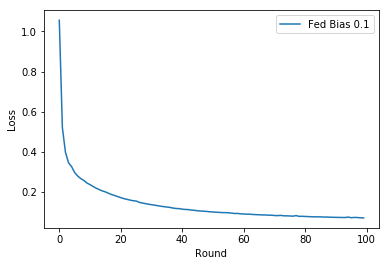

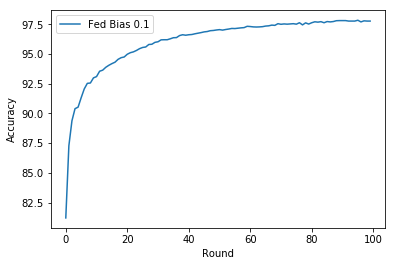

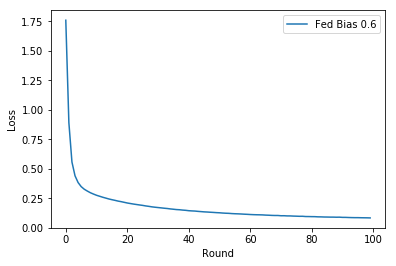

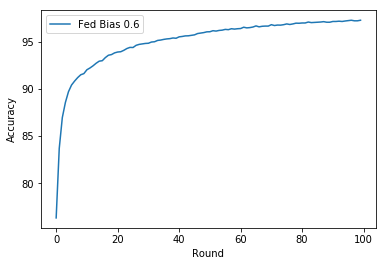

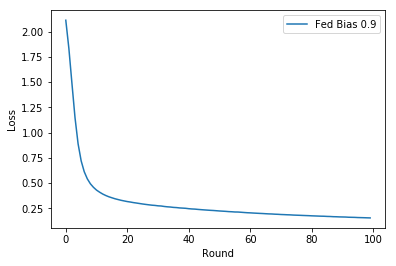

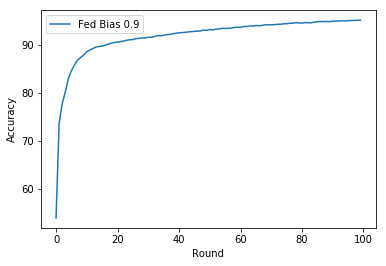

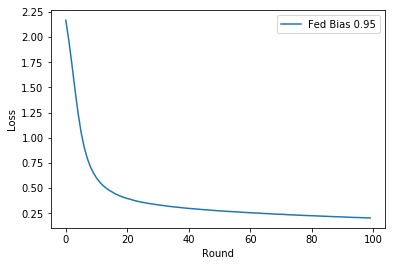

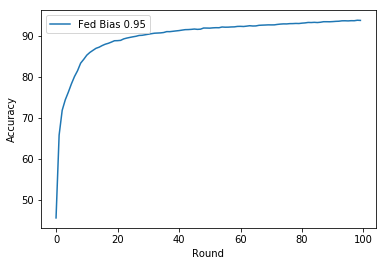

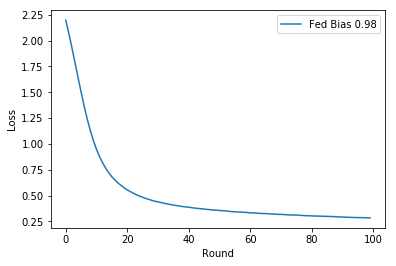

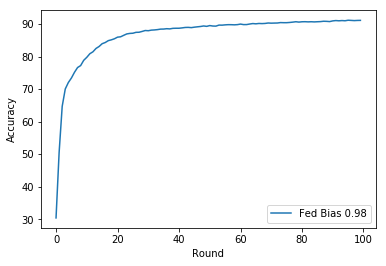

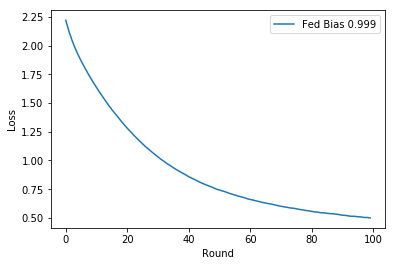

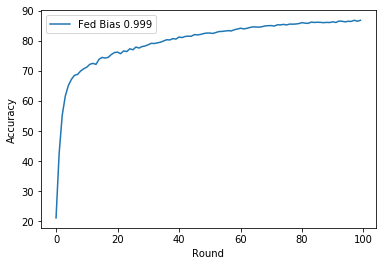

In [14]:
mgrs = [eval_mgr(('Fed Bias '+ str(x)), train_dset, test_dset, p=x, num_rounds=100, target_acc=None) for x in [0.0, 0.1, 0.6, 0.9, 0.95, 0.98, 0.999]]

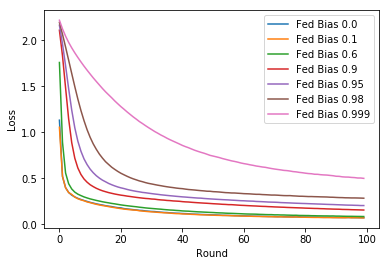

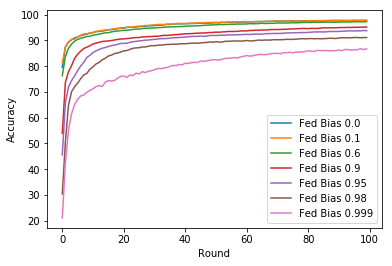

In [15]:
plot_mgr(mgrs)

In [28]:
# find the number of rounds to hit the target accuracy

def rounds_to_target(mgrs, target_acc = 95.0):
    for m in mgrs:
        target_met = False
        for i in range(len(m.history['test_acc'])):
            if m.history['test_acc'][i] >= target_acc:
                print(m.name, 'manager met target', target_acc, '% accuracy: ', m.history['test_acc'][i], '% after round', i)
                target_met = True
                break;
        if not target_met:
            print(m.name, 'manager did not meet target', target_acc, '% accuracy. Reached', m.history['test_acc'][-1], '% after round', len(m.history['test_acc'])-1)
            
rounds_to_target(mgrs, 95.0)

Fed Bias 0.0 manager met target 95.0 % accuracy:  95.03 % after round 21
Fed Bias 0.1 manager met target 95.0 % accuracy:  95.11 % after round 21
Fed Bias 0.6 manager met target 95.0 % accuracy:  95.0 % after round 32
Fed Bias 0.9 manager met target 95.0 % accuracy:  95.01 % after round 90
Fed Bias 0.95 manager did not meet target 95.0 % accuracy. Reached 93.8 % after round 99
Fed Bias 0.98 manager did not meet target 95.0 % accuracy. Reached 91.12 % after round 99
Fed Bias 0.999 manager did not meet target 95.0 % accuracy. Reached 86.75 % after round 99


In [29]:
# Need to parameterize this better

def eval_stacks(biases, target_acc):
    
    mgrs = []
    
    for b in tqdm(biases, desc='building datasets'):
        stacked_dsets = fm.make_stacked_dsets(train_dset, p=b)
        fm.check_dsets(stacked_dsets)

        stk_mgr = federated.FederatedManager(
            [DataLoader(dset, batch_size=train_batch_size, shuffle=True)
                                for dset in stacked_dsets],
            Net,
            nn.CrossEntropyLoss(),
            test_dset,
            num_epochs,
            learning_rate,
            verbose
        )
        mgrs.append(stk_mgr)
        
    for mgr in tqdm(mgrs, desc='evaluating managers'):
        run_manager(mgr, num_rounds)

    plot_loss(mgrs)
    plot_acc(mgrs)
    rounds_to_target(mgrs)

In [ ]:
#eval_stacks([0.0, 0.1, 0.2, 0.4, 0.8, 0.9, 0.95, 0.98, 1.0], 95.0)

In [ ]:
eval_stacks([0.0, 0.1, 0.99, 0.999, 1.0], 95.0)

In [ ]:
# TODO Make a setting for a manager to halt on a target accuracy

In [ ]:
fm.main()

# Conclusion
TODO: WRAP UP THE BLOG POST HERE. EVERYTHING BELOW IS PART TWO OR THREE